<a href="https://colab.research.google.com/github/dahouda2pro/XAI-Image-Class-ViT/blob/main/XAI_Image_Class_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install GPy, GPyOpt
#!pip install GPy
#!pip install GPyOpt
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached GPy-1.10.0.tar.gz (959 kB)
  Preparing metadata (setup.py) ... done
  Using cached paramz-0.9.5.tar.gz (71 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=8053fd27bcaea8106ac5e521262a584e80fa1d36ef2f8aa109b98639865447e3
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420167 sha256=e92326717e46ba0d2d845cd48354789b1dcc82dd60d308564ca4f235be2af13f
  Stored in dire

In [2]:
# Install GPy, GPyOpt
##!pip install GPy==1.9.8
#!pip install GPyOpt==1.2.1
#!pip install tensorflow-addons

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
!python3 --version
#Python 3.6.9
print(tf.__version__)
#2.3.0
#print(K.__version__)
#2.4.0
print(np.__version__)
#1.18.5
#print(matplotlib.__version__)
#3.2.2
print(GPy.__version__)
#1.9.8
print(GPyOpt.__version__)
#1.2.1

Python 3.10.12
2.14.0
1.23.5
1.10.0
1.2.6


In [4]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    #X = K.applications.NASNetLarge.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [5]:

# load the Cifar100 dataset, 50,000 training images and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar100.load_data()

# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)



num_classes = 100
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


Configure the hyperparameters

In [6]:
class Config:
    input_size = 32
    input_shape = [input_size, input_size, 3]
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 100
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [7]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [8]:
(train_data, train_labels),(test_data, test_labels)  = keras.datasets.cifar100.load_data()
(train_data.shape, train_labels.shape),(test_data.shape, test_labels.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

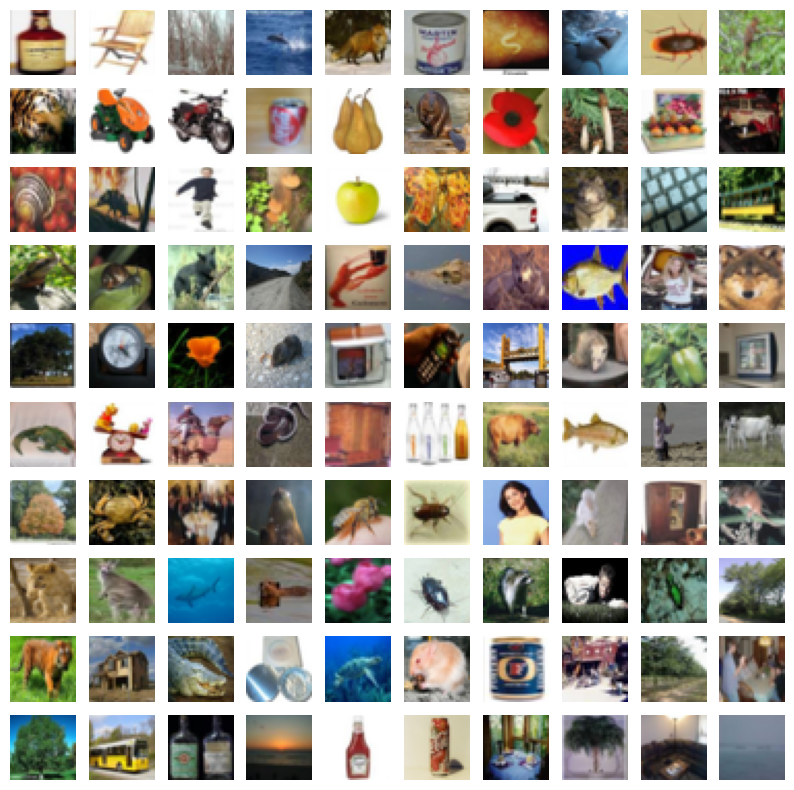

In [9]:
indices = np.random.choice(train_data.shape[0], 100)
sample_images(train_data[indices], 10, 10)

 Use data augmentation

In [10]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [11]:
augmentation_layer.layers[0].adapt(train_data)

 Implement multilayer perceptron (MLP)

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [13]:
# Implement patch creation as a layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(32, 32, 3)
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches Sahpe: (1, 144, 108)
Patches per image: 144
Elements per patch: 108


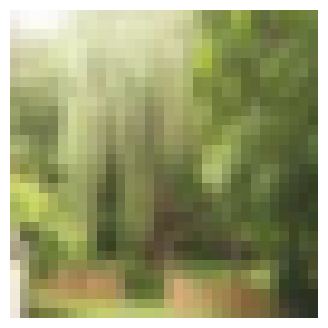

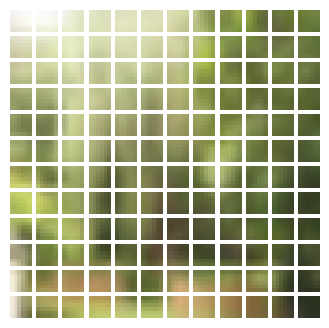

In [14]:

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches Sahpe: {patches.shape}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [15]:
"""
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

"""
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model

In [16]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads,
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Compile, train, and evaluate the model

In [17]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 72, 72, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches[0][0]']             
 r)                                                                                           

In [18]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [19]:
history = vit_classifier.fit(train_data, train_labels, verbose=1, epochs=50, batch_size=Config.batch_size, validation_data=(test_data, test_labels), callbacks=[checkpoint])

Epoch 1/50
196/196 [==============================] - 90s 371ms/step - loss: 4.4608 - accuracy: 0.0455 - val_loss: 3.8626 - val_accuracy: 0.1233
Epoch 2/50
196/196 [==============================] - 72s 366ms/step - loss: 3.9374 - accuracy: 0.0934 - val_loss: 3.4709 - val_accuracy: 0.1769
Epoch 3/50
196/196 [==============================] - 72s 366ms/step - loss: 3.6690 - accuracy: 0.1337 - val_loss: 3.3404 - val_accuracy: 0.1998
Epoch 4/50
196/196 [==============================] - 72s 370ms/step - loss: 3.4946 - accuracy: 0.1621 - val_loss: 3.1295 - val_accuracy: 0.2452
Epoch 5/50
196/196 [==============================] - 73s 374ms/step - loss: 3.3414 - accuracy: 0.1911 - val_loss: 3.0339 - val_accuracy: 0.2664
Epoch 6/50
196/196 [==============================] - 74s 375ms/step - loss: 3.2175 - accuracy: 0.2164 - val_loss: 2.9375 - val_accuracy: 0.2810
Epoch 7/50
196/196 [==============================] - 73s 375ms/step - loss: 3.0885 - accuracy: 0.2397 - val_loss: 2.8005 - val_ac

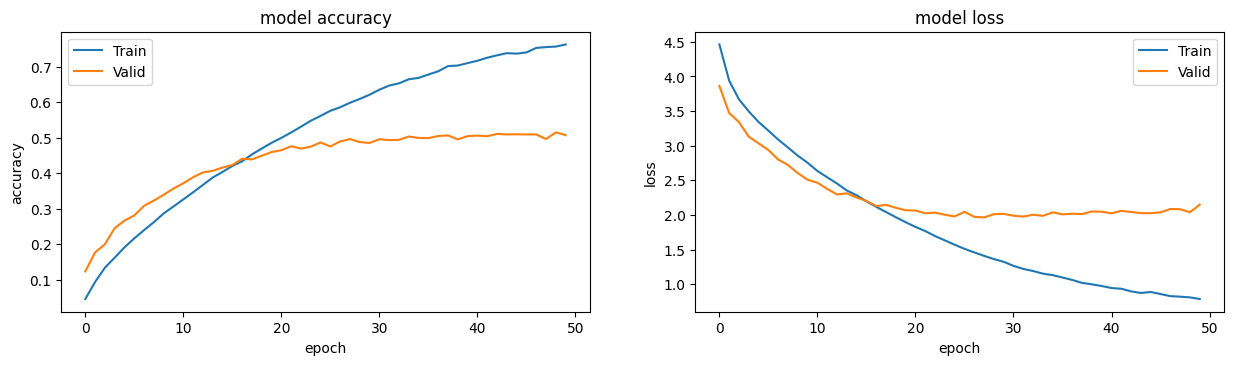

In [20]:
  # print(history_dict)
plot = 0
def plot_history(history):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Valid'])
    plot = 0
    plt.savefig('Loss_Acc_'+str(plot)+'.pdf')
    plt.savefig('Loss_Acc_'+str(plot)+'.png')
    plot = plot + 1
    plt.show()

  # plot the model accuracy and loss results
plot_history(history)

In [21]:
#_,accuracy, top_5_accuracy = vit_classifier(test_data, test_labels)
#print(f"Test Accuracy: {round(accuracy * 100)}%")
#print(f"Test Top 5 Accuracy: {round(top_5_accuracy * 100, 2)}%")